In [20]:
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import pandas as pd
from sklearn.model_selection import KFold
import scipy.stats
import warnings
from copy import copy

warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#Plotting function
from PlotDecodingResults import ModelPredictionPlots
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from RunKeras import NaiveBayes as nb
from RunKeras import PrepareBehaviorData as pbd

nb = nb()
m = ModelPredictionPlots()

Validation functions


## Get Data for training and testing

In [22]:
task_dict = {'Task1':'1 Fam Rew', 
             'Task2':'2 No Rew', 
             'Task3':'3 Fam Rew', 
             'Task4':'4 Nov Rew'}

In [23]:
FolderName = '/home/sheffieldlab/Desktop/NoReward/ImagingData/Good_behavior/NR6/'

frame_lick_stop = 5154
task_numframes = {'Task1': 20000, 
                  'Task2': 20000, 
                  'Task3': 15000, 
                  'Task4': 15000}
#Track Parameters
tracklength = 200 #2m track
trackbins = 5 #5cm bins

In [24]:
SaveResults = os.path.join(FolderName, 'DecoderResults', 'BayesDecoder')
if not os.path.exists(SaveResults):
    os.mkdir(SaveResults)

In [25]:
from Placecells_and_LickCorrelation_EachAnimal import GetData as gd
A = gd(FolderName=FolderName, Task_NumFrames=task_numframes, TaskDict=task_dict, lick_stop=frame_lick_stop)

Number of PlaceCells in Task2 is 129
Number of PlaceCells in Task1 is 133
Number of PlaceCells in Task3 is 123
Number of PlaceCells in Task4 is 119
Number of PlaceCells in Task2a is 129


In [26]:
# Get Xdata - calcium data and Ydata - running behavior
X = A.Fc3data_dict['Task1'][:, A.Parsed_Behavior['good_running_index'].item()['Task1']].T[:11000, :]
Y = A.Parsed_Behavior['good_running_data'].item()['Task1'][:11000, :]
print(np.shape(X), np.shape(Y))

(11000, 316) (11000, 1)


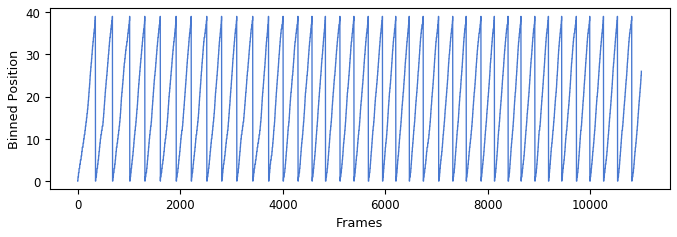

In [27]:
B = pbd(BehaviorData=Y, tracklength=tracklength, trackbins=trackbins)
y_cat = B.position_binary

In [28]:
#Split testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.10, random_state=None, shuffle=False)
print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

(9900, 316) (1100, 316) (9900,) (1100,)


### Run Naive Bayes


Accuracy of test set:: 0.35%


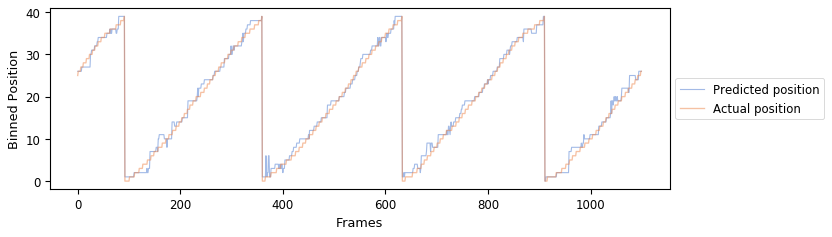

In [29]:
gaussianNB = nb.fit_naivebayes(X_train, y_train)
scores, y_predicted, y_errorprob = nb.validate_model(gaussianNB, X_test, y_test)

In [30]:
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' %R2)
print(f'rho: %.2f' %rho)

R2: 0.99
rho: 1.00


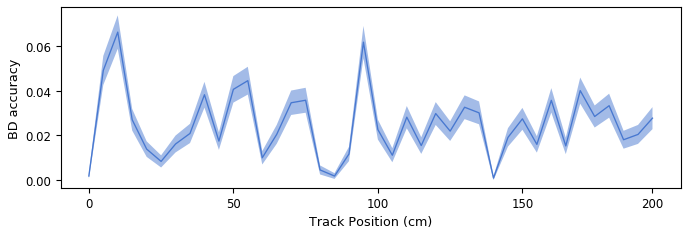

In [31]:
nb.plot_error_probability(y_errorprob)

In [32]:
np.savez(os.path.join(SaveResults, 'FinalBayesFit.npz'),
         X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
         R2=R2, rho=rho, y_predicted=y_predicted, y_probability=y_errorprob)

### K-fold validation of model

In [33]:
from sklearn.model_selection import KFold

In [34]:
#Define k-fold validation
k = KFold(n_splits=5, random_state=None, shuffle=False)

In [2]:
print(f'Performing %d-fold validation' % k.n_splits)
count_cv = 1
nbcv_dataframe = pd.DataFrame(
    columns=['CVIndex', 'ModelAccuracy', 'Y_test', 'Y_predict', 'Y_diff', 'mean_errorprob', 'sem_errorprob'])
for train_index, test_index in k.split(X):
    print(f'Validation %d' % count_cv)
    xcv_train, xcv_test = X[train_index], X[test_index]
    ycv_train, ycv_test = y_cat[train_index], y_cat[test_index]

    print(np.shape(xcv_train), np.shape(ycv_train),
          np.shape(xcv_test), np.shape(ycv_test))
    cvsnbmodel = nb.fit_naivebayes(xcv_train, ycv_train)

    # evaluate the model and save evalautions
    scores, ycv_predict, ycv_probability = nb.validate_model(
        cvsnbmodel, xcv_test, ycv_test)
    nbcv_dataframe = nbcv_dataframe.append({'CVIndex': count_cv,
                                            'ModelAccuracy': scores,
                                            'Y_test': ycv_test,
                                            'Y_predict': ycv_predict,
                                            'Y_diff': np.abs(ycv_test-ycv_predict),
                                            'mean_errorprob': np.mean(ycv_probability, 0),
                                            'sem_errorprob': scipy.stats.sem(ycv_probability, 0)}, 
                                            ignore_index=True)
    count_cv += 1

NameError: name 'k' is not defined

Validation functions
R2: 0.99 +/- 0.003274
Rho: 0.99 +/- 0.001662


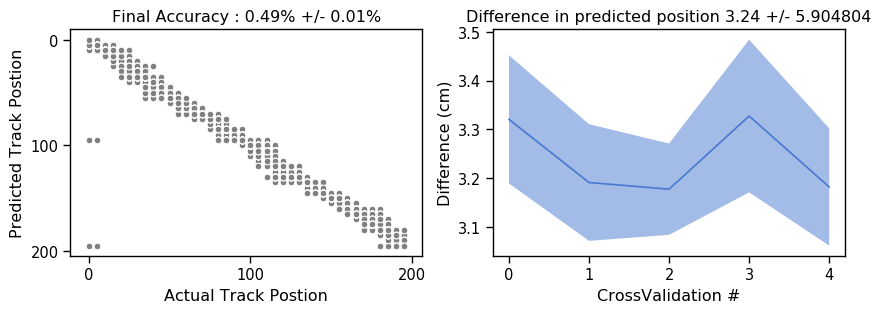

In [17]:
m = ModelPredictionPlots()
m.PlotCVResult(cv_dataframe=nbcv_dataframe, trackbins=trackbins, numsplits=k.n_splits)

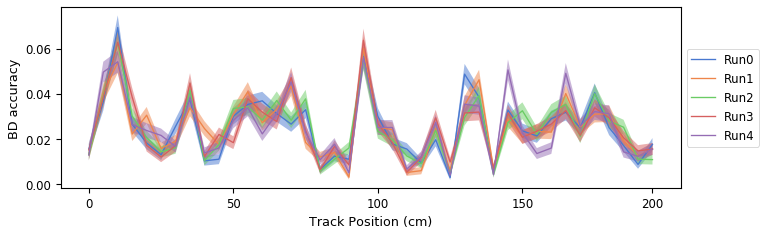

In [18]:
m.plot_bayes_probability(nbcv_dataframe)

In [19]:
#Save CSV
nbcv_dataframe.to_pickle(os.path.join(SaveResults, f'%d-foldevaluation.pkl'%k.n_splits))

### Get accuracy with number of cells

#### With all cells

In [20]:
numsamples, R2_numcells_dict_cntrl, rho_numcells_dict_cntrl = nb.decoderaccuracy_wtih_numcells(X_data=X, Y_data=y_cat, iterations=100)

Validation functions
Fitting on 31 neurons

Accuracy of test set:: 0.17%

Accuracy of test set:: 0.11%

Accuracy of test set:: 0.17%

Accuracy of test set:: 0.11%

Accuracy of test set:: 0.11%

Accuracy of test set:: 0.16%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.17%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.10%

Accuracy of test set:: 0.20%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.17%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.11%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.17%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.11%

Accuracy of test set:: 0.16%

Accuracy of test set:: 0.22%

Accuracy of test set:: 0.11%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.19%

Accuracy of test set:: 0.0


Accuracy of test set:: 0.27%

Accuracy of test set:: 0.32%

Accuracy of test set:: 0.28%

Accuracy of test set:: 0.27%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.28%

Accuracy of test set:: 0.25%

Accuracy of test set:: 0.25%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.28%

Accuracy of test set:: 0.27%

Accuracy of test set:: 0.21%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.26%

Accuracy of test set:: 0.28%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.27%

Accuracy of test set:: 0.27%

Accuracy of test set:: 0.25%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.27%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.30%
Fitting on 252 neurons

Accuracy of test set:: 0.33%

Accuracy of test set:: 0.32%

Accuracy of test set:: 0.32%

Accuracy of test

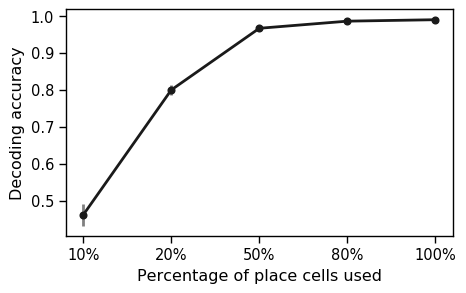

In [21]:
mean_R2_cntrl, sem_R2_cntrl = nb.plot_decoderaccuracy_with_numcells(R2_numcells_dict_cntrl, numsamples)

#### With only place cells

In [22]:
X_pfs = X[:, A.sig_PFs_cellnum_dict['Task1']]
print(np.shape(X_pfs))
numsamples, R2_numcells_dict_cntrl_pfs, rho_numcells_dict_cntrl_pfs = nb.decoderaccuracy_wtih_numcells(X_data=X_pfs, Y_data=y_cat, iterations=100)

(11000, 133)
Validation functions
Fitting on 13 neurons

Accuracy of test set:: 0.19%

Accuracy of test set:: 0.18%

Accuracy of test set:: 0.19%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.18%

Accuracy of test set:: 0.20%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.11%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.24%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.21%

Accuracy of test set:: 0.16%

Accuracy of test set:: 0.16%

Accuracy of test set:: 0.19%

Accuracy of test set:: 0.19%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.15%

Accuracy of test set:: 0.10%

Accuracy of test set:: 0.17%

Accuracy of test set:: 0.16%

Accuracy of test set:: 0.17%

Accuracy of test set:: 0.21%

Accuracy of test set:: 0.19%

Accuracy of test set:: 0.13%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.11%

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.18%

Accuracy of test set:: 0.24%

Accuracy of t


Accuracy of test set:: 0.29%

Accuracy of test set:: 0.27%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.24%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.36%

Accuracy of test set:: 0.30%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.26%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.38%

Accuracy of test set:: 0.26%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.28%

Accuracy of test set:: 0.24%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.29%

Accuracy of test set:: 0.33%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.26%

Accuracy of test set:: 0.34%

Accuracy of test set:: 0.34%

Accuracy of test set:: 0.32%

Accuracy of test set:: 0.27%

Accuracy of test set:: 0.33%
Fitting on 106 neurons

Accuracy of test set:: 0.33%

Accuracy of test set:: 0.31%

Accuracy of test set:: 0.32%

Accuracy of test

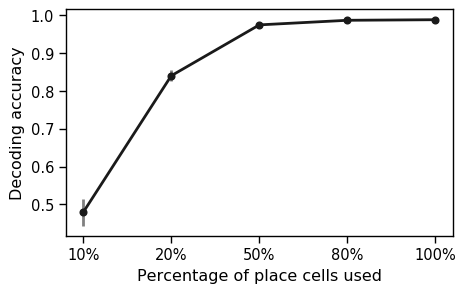

In [23]:
mean_R2_cntrl_pfs, sem_R2_cntrl_pfs = nb.plot_decoderaccuracy_with_numcells(R2_numcells_dict_cntrl_pfs, numsamples)

#### Without place cells

In [24]:
pfs = A.sig_PFs_cellnum_dict['Task1']
temp_shape = np.arange(X.shape[1])
notpfs = np.setxor1d(temp_shape, pfs)
X_notpfs = X[:, notpfs]
print(np.shape(X_notpfs))

(11000, 183)


In [25]:
numsamples, R2_numcells_dict_cntrl_notpfs, rho_numcells_dict_cntrl_notpfs = nb.decoderaccuracy_wtih_numcells(X_data=X_notpfs, Y_data=y_cat, iterations=100)

Validation functions
Fitting on 18 neurons

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.04%

Accuracy of test set:: 0.04%

Accuracy of test set:: 0.02%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.04%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.02%

Accuracy of test set:: 0.04%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.04%

Accuracy of test set:: 0.04%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.02%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.06%

Accuracy of test set:: 0.02%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.04%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.03%

Accuracy of test set:: 0.07%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.0


Accuracy of test set:: 0.09%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.07%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.07%

Accuracy of test set:: 0.06%

Accuracy of test set:: 0.07%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.10%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.12%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.07%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.06%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.10%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.05%

Accuracy of test set:: 0.10%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.08%

Accuracy of test set:: 0.07%

Accuracy of test set:: 0.09%

Accuracy of test set:: 0.09%
Fitting on 146 neurons

Accuracy of test set:: 0.14%

Accuracy of test set:: 0.11%

Accuracy of test set:: 0.10%

Accuracy of test set:: 0.12%

Accuracy of test

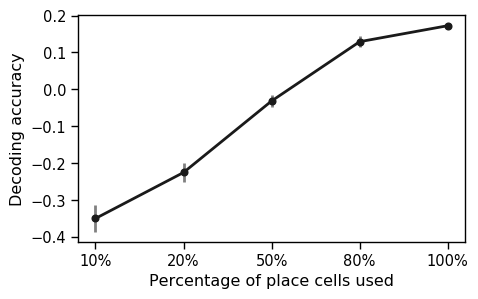

In [26]:
mean_R2_cntrl_notpfs, sem_R2_cntrl_notpfs = nb.plot_decoderaccuracy_with_numcells(R2_numcells_dict_cntrl_notpfs, numsamples)

#### Plot all together

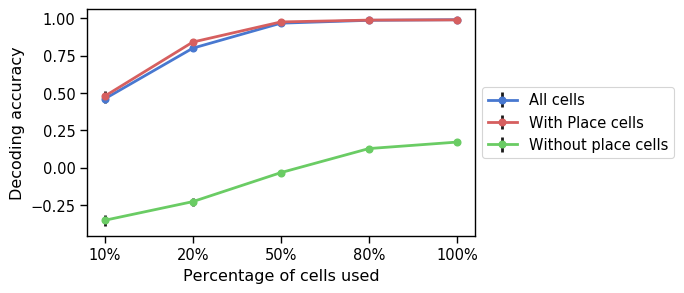

In [27]:
plt.figure(figsize=(5, 3), dpi=100)
plt.errorbar(np.arange(np.size(numsamples)), mean_R2_cntrl, yerr=sem_R2_cntrl, color='b', fmt='o-', ecolor='k', capthick=5, linewidth=2, label='All cells')
plt.errorbar(np.arange(np.size(numsamples)), mean_R2_cntrl_pfs, yerr=sem_R2_cntrl_pfs, color='r', fmt='o-', ecolor='k', capthick=5, linewidth=2, label='With Place cells')
plt.errorbar(np.arange(np.size(numsamples)), mean_R2_cntrl_notpfs, yerr=sem_R2_cntrl_notpfs, color='g', fmt='o-', ecolor='k', capthick=5, linewidth=2, label='Without place cells')
plt.xticks(np.arange(np.size(numsamples)), ['10%', '20%', '50%', '80%', '100%'])
plt.xlabel('Percentage of cells used')
plt.ylabel('R-squared');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))